In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from functions import evaluate_model

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.manifold import TSNE

import keras
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model

from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

In [2]:
mitbih_test = pd.read_csv("data/mitbih_test.csv", header=None)
mitbih_train = pd.read_csv("data/mitbih_train.csv", header=None)
mitbih_bi_train=mitbih_train.iloc[: , :-1]
label_col=mitbih_train[187].replace({2: 1, 3: 1, 4:1})
mitbih_bi_train[187] = label_col

In [3]:
ptbdb_abnormal = pd.read_csv("data/ptbdb_abnormal.csv", header=None)
ptbdb_normal = pd.read_csv("data/ptbdb_normal.csv", header=None)
ptbdb = pd.concat([ptbdb_normal,ptbdb_abnormal], axis=0, ignore_index=True)

In [4]:
mitbih_train[187]=mitbih_train[187].astype(int)
equilibre=mitbih_train[187].value_counts()
print(equilibre)

from sklearn.utils import resample
df_1=mitbih_train[mitbih_train[187]==1]
df_2=mitbih_train[mitbih_train[187]==2]
df_3=mitbih_train[mitbih_train[187]==3]
df_4=mitbih_train[mitbih_train[187]==4]
df_0=(mitbih_train[mitbih_train[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

mitbih_train=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])
equilibre=mitbih_train[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64
0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


In [ ]:
#function to noise the train
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)

In [6]:
target_train=mitbih_train[187]
target_test=mitbih_test[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [7]:
X_train=mitbih_train.iloc[:,:186].values
X_test=mitbih_test.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [8]:
# def get_base_model(categories=2):
#     return keras.Sequential([
#     keras.layers.Dense(15, activation='relu', input_shape=[187], kernel_regularizer=regularizers.l2(0.0001)),
#     keras.layers.Dense(10, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
#     keras.layers.Dense(5, activation='relu'),
#     (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
#   ])


In [9]:
def base_model(X_train,y_train,X_test,y_test,cat=5):
    im_shape=(X_train.shape[1])
    inputs_mlp=Input(shape=(im_shape), name='inputs_mlp')
    dense1=Dense(64, activation='relu')(inputs_mlp)
    dense2=Dense(64, activation='relu')(dense1)
    dense3=Dense(32, activation='relu')(dense2)
    if cat==5:
        main_output=Dense(5, activation='softmax')(dense3)
    if cat==2:
        main_output=Dense(1, activation='sigmoid')(dense3)
        
    model = Model(inputs= inputs_mlp, outputs=main_output)
    if cat==5:
        model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    if cat==2:
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='models/best_base_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('models/best_base_model.h5')
    return(model,history)

def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [11]:
model,history=base_model(X_train,y_train,X_test,y_test)

2022-09-05 08:44:59.683532: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/40
3125/3125 [==============================] - 8s 2ms/step - loss: 0.9995 - accuracy: 0.6045 - val_loss: 1.1065 - val_accuracy: 0.5040
Epoch 2/40
3125/3125 [==============================] - 6s 2ms/step - loss: 0.8546 - accuracy: 0.6720 - val_loss: 0.9212 - val_accuracy: 0.6146
Epoch 3/40
3125/3125 [==============================] - 7s 2ms/step - loss: 0.8136 - accuracy: 0.6894 - val_loss: 0.9871 - val_accuracy: 0.5793
Epoch 4/40
3125/3125 [==============================] - 7s 2ms/step - loss: 0.7884 - accuracy: 0.6993 - val_loss: 1.0359 - val_accuracy: 0.5649
Epoch 5/40
3125/3125 [==============================] - 8s 2ms/step - loss: 0.7698 - accuracy: 0.7073 - val_loss: 1.0773 - val_accuracy: 0.5375
Epoch 6/40
3125/3125 [==============================] - 7s 2ms/step - loss: 0.7548 - accuracy: 0.7122 - val_loss: 0.9211 - val_accuracy: 0.6336
Epoch 7/40
3125/3125 [==============================] - 7s 2ms/step - loss: 0.7420 - accuracy: 0.7180 - val_loss: 0.9016 - val_accuracy:

Accuracy: 64.96%


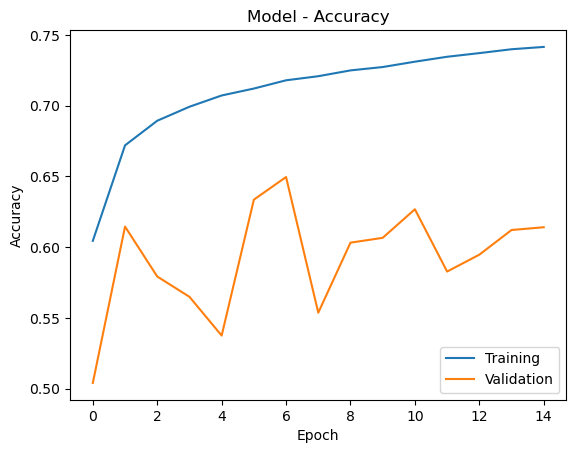

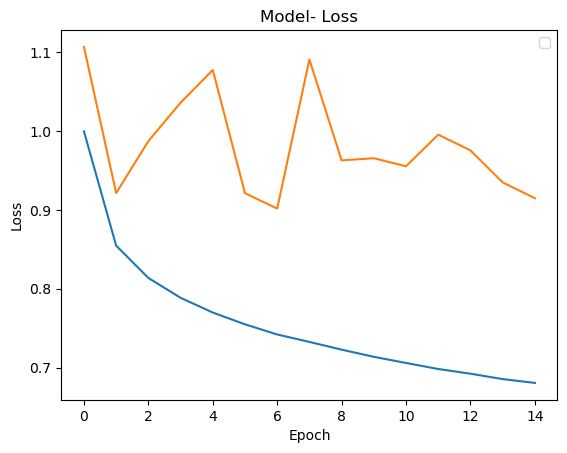

685/685 [==============================] - 1s 1ms/step


In [12]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [13]:
intermediate_layer_model_base = Model(inputs=model.input,
                                 outputs=model.layers[-4].output)
embed_test_base = intermediate_layer_model_base.predict(X_test)

685/685 [==============================] - 1s 941us/step


In [14]:
tsne = TSNE(n_components=2)
tsne_embed_test_base = tsne.fit_transform(embed_test_base)

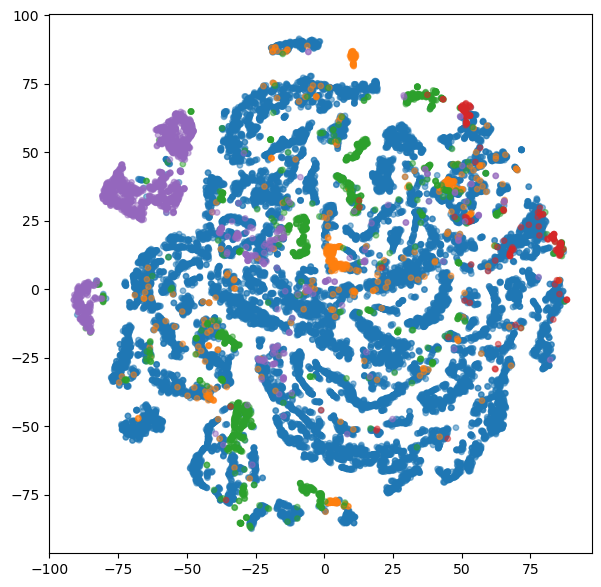

In [15]:
ecg_colors = np.asarray(['C0', 'C1', 'C2', 'C3', 'C4'])[np.argmax(y_test, axis=1)]
plt.figure(figsize=(7, 7))
plt.scatter(*tsne_embed_test_base.T, c=ecg_colors, s=15, alpha=0.5)

model,history=network(X_train,y_train,X_test,y_test)

evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [16]:
def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(kernels, stride, padding='same')(X)
    out = keras.layers.ReLU()(out)
    out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(5, 2)(out)
    return out

In [17]:
def resnet(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_resnet')
    kernels=32
    stride=5
    X = residual_block(inputs_cnn, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    X = residual_block(X, kernels, stride)
    
    flatten=Flatten()(X)
    
    
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='models/best_model_resnet.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('models/best_model_resnet.h5')
    return(model,history)



In [18]:
model,history=resnet(X_train,y_train,X_test,y_test)

Epoch 1/40
3125/3125 [==============================] - 102s 32ms/step - loss: 0.9597 - accuracy: 0.6254 - val_loss: 0.8480 - val_accuracy: 0.6580
Epoch 2/40
3125/3125 [==============================] - 101s 32ms/step - loss: 0.8295 - accuracy: 0.6852 - val_loss: 0.7337 - val_accuracy: 0.7476
Epoch 3/40
3125/3125 [==============================] - 103s 33ms/step - loss: 0.8004 - accuracy: 0.6976 - val_loss: 0.9182 - val_accuracy: 0.6993
Epoch 4/40
3125/3125 [==============================] - 103s 33ms/step - loss: 0.7817 - accuracy: 0.7042 - val_loss: 0.7509 - val_accuracy: 0.7482
Epoch 5/40
3125/3125 [==============================] - 104s 33ms/step - loss: 0.7706 - accuracy: 0.7082 - val_loss: 0.7269 - val_accuracy: 0.7686
Epoch 6/40
3125/3125 [==============================] - 104s 33ms/step - loss: 0.7615 - accuracy: 0.7114 - val_loss: 0.8582 - val_accuracy: 0.6860
Epoch 7/40
3125/3125 [==============================] - 105s 34ms/step - loss: 0.7535 - accuracy: 0.7149 - val_loss: 0

Accuracy: 78.91%


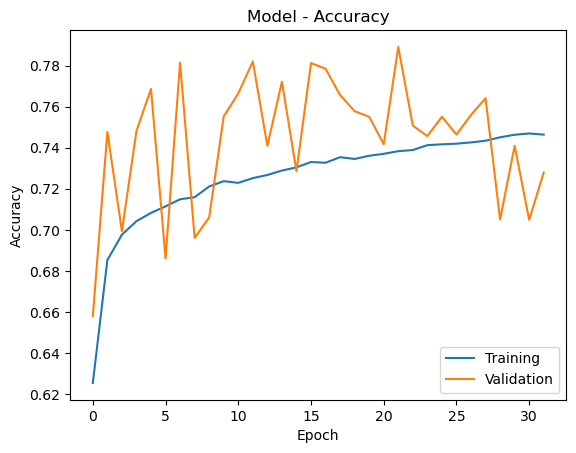

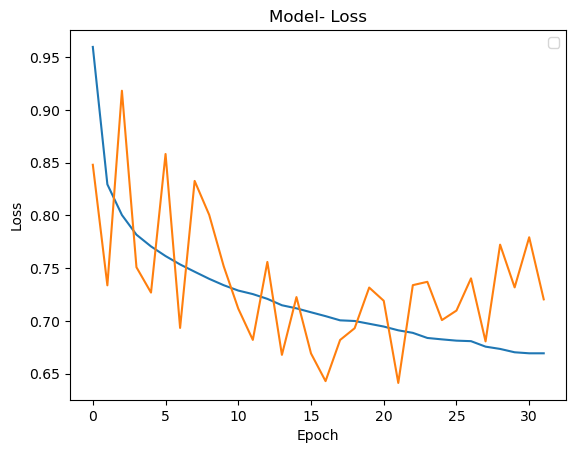

685/685 [==============================] - 5s 7ms/step


In [19]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [20]:
intermediate_layer_model_resnet = Model(inputs=model.input,
                                 outputs=model.layers[-4].output)
embed_test_resnet = intermediate_layer_model_resnet.predict(X_test)

685/685 [==============================] - 4s 6ms/step


In [21]:
tsne = TSNE(n_components=2)
tsne_embed_test_resnet = tsne.fit_transform(embed_test_resnet)

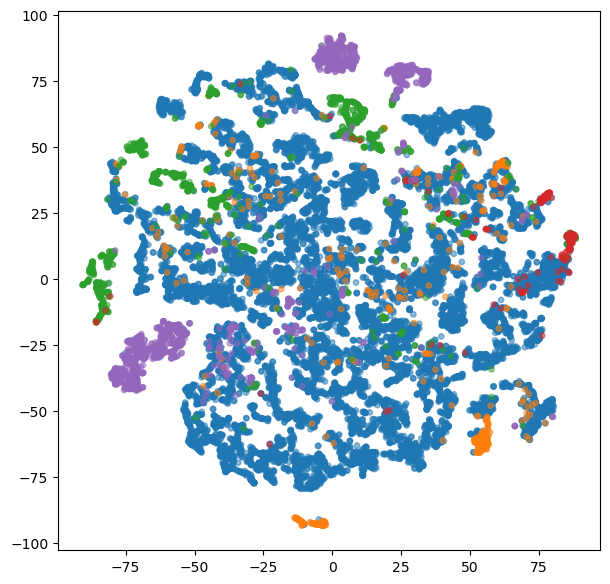

In [22]:
ecg_colors = np.asarray(['C0', 'C1', 'C2', 'C3', 'C4'])[np.argmax(y_test, axis=1)]
plt.figure(figsize=(7, 7))
plt.scatter(*tsne_embed_test_resnet.T, c=ecg_colors, s=15, alpha=0.5)

In [23]:
def lstm(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs=Input(shape=(im_shape), name='inputs_lstm')
    lstm1 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(inputs)
    lstm2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(lstm1)
   
    flatten=Flatten()(lstm2)
    
    
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs= inputs, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='models/best_model_lstm.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('models/best_model_lstm.h5')
    return(model,history)

In [24]:
model,history=lstm(X_train,y_train,X_test,y_test)

Epoch 1/40
3125/3125 [==============================] - 785s 249ms/step - loss: 0.8600 - accuracy: 0.6737 - val_loss: 1.0583 - val_accuracy: 0.5903
Epoch 2/40
3125/3125 [==============================] - 793s 254ms/step - loss: 0.7628 - accuracy: 0.7129 - val_loss: 0.7838 - val_accuracy: 0.7410
Epoch 3/40
3125/3125 [==============================] - 793s 254ms/step - loss: 0.7241 - accuracy: 0.7272 - val_loss: 0.7837 - val_accuracy: 0.7199
Epoch 4/40
3125/3125 [==============================] - 811s 260ms/step - loss: 0.6865 - accuracy: 0.7408 - val_loss: 0.7740 - val_accuracy: 0.7129
Epoch 5/40
3125/3125 [==============================] - 810s 259ms/step - loss: 0.6367 - accuracy: 0.7609 - val_loss: 0.8167 - val_accuracy: 0.6941
Epoch 6/40
3125/3125 [==============================] - 827s 265ms/step - loss: 0.5627 - accuracy: 0.7885 - val_loss: 0.7128 - val_accuracy: 0.7387
Epoch 7/40
3125/3125 [==============================] - 819s 262ms/step - loss: 0.4555 - accuracy: 0.8309 - val_

Accuracy: 73.87%


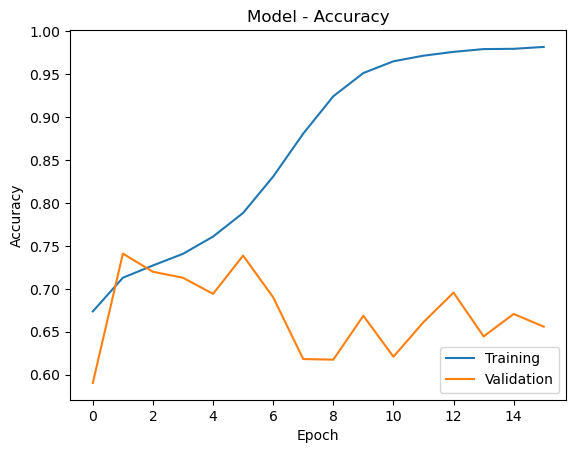

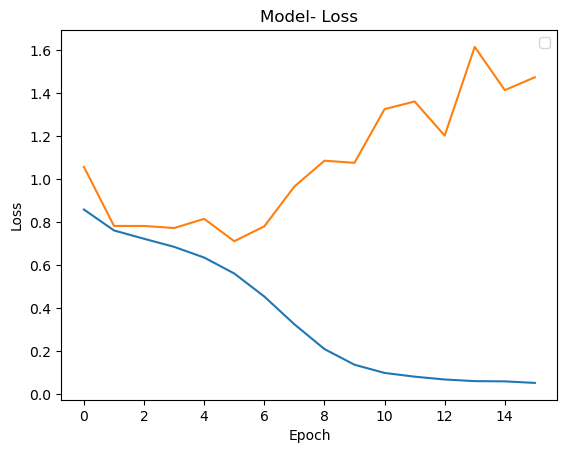

685/685 [==============================] - 56s 81ms/step


In [25]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

In [26]:
model.layers[-4].output

<KerasTensor: shape=(None, 23808) dtype=float32 (created by layer 'flatten_1')>

In [27]:
intermediate_layer_model_lstm = Model(inputs=model.input,
                                 outputs=model.layers[-4].output)
embed_test_lstm = intermediate_layer_model_lstm.predict(X_test)

685/685 [==============================] - 57s 81ms/step


In [28]:
tsne = TSNE(n_components=2)
tsne_embed_test_lstm = tsne.fit_transform(embed_test_lstm)

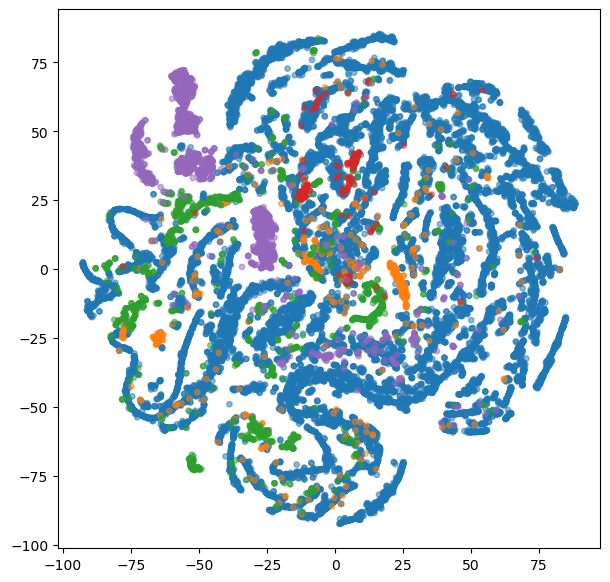

In [29]:
ecg_colors = np.asarray(['C0', 'C1', 'C2', 'C3', 'C4'])[np.argmax(y_test, axis=1)]
plt.figure(figsize=(7, 7))
plt.scatter(*tsne_embed_test_lstm.T, c=ecg_colors, s=15, alpha=0.5)